### Importing the necessary libraries

In [ ]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Setting up the data

In [ ]:
import os
import zipfile
import pathlib
import requests

DATA_PATH = pathlib.Path('Data')
IMG_FOLDER = DATA_PATH/'pizza_steak_sushi'
if IMG_FOLDER.is_dir():
  print(f'{IMG_FOLDER} already exists, Skipping the creation part...')
else:
  IMG_FOLDER.mkdir(parents=True, exist_ok=True)

ZIP_PATH = DATA_PATH/'pizza_steak_sushi.zip'
if ZIP_PATH.is_dir():
  print(f'{ZIP_PATH} already exists, Skipping download...')
else:
  with open(ZIP_PATH, 'wb') as f:
    req = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    f.write(req.content)

with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
  zip_ref.extractall(IMG_FOLDER)

os.remove(ZIP_PATH)


### Creating the train and test directories

In [ ]:
train_dir = IMG_FOLDER/'train'
test_dir = IMG_FOLDER/'test'

### Creating datasets and dataloaders

In [ ]:
from torchvision.transforms import ToTensor
import data_setup

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

NUM_EPOCHS = 5
NUM_BATCHES = 32

train_dataLoader, test_dataLoader, num_classes, class_to_idx = data_setup.data_loaders(train_dir=train_dir, test_dir=test_dir, batch_size=NUM_BATCHES,
                        data_transform= manual_transforms, num_os_workers=os.cpu_count())

### Selecting a pre trained model for our data

In [ ]:
from torchvision import models

pre_weights = models.EfficientNet_B0_Weights.DEFAULT
pre_weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [ ]:
auto_transforms = pre_weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### Creating datasets and dataloaders with auto transforms

In [ ]:
train_dataLoader, test_dataLoader, num_classes, class_to_idx = data_setup.data_loaders(train_dir=train_dir, test_dir=test_dir, batch_size=NUM_BATCHES,
                        data_transform= auto_transforms, num_os_workers=os.cpu_count())

In [ ]:
! pip install -q efficientnet_pytorch

  Preparing metadata (setup.py) ... done


### Downloading the pretrained weights

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 145MB/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
! pip install -q torchinfo

### Model's Summary

In [ ]:
from torchinfo import summary

summary(model= model, input_size=(32,3,224,224),
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20, row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─ZeroPad2d (static_padding)                            [32, 3, 224, 224]    [32, 3, 225, 225]    --                   --
├─BatchNorm2d (_bn0)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
├─MemoryEfficientSwish (_swish)                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   True
│    └─MBConvBlock (0)                                       [32, 32, 112, 112]   [32, 16, 112, 

### We will freeze the base model (all features) and just change the head layer for our use case

### Freezing the base model

In [ ]:
for param in model.parameters():
  param.requires_grad = False


### Changing the output layer

In [ ]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

output_shape = len(num_classes)

model._fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model._fc.in_features,
                        out_features=output_shape,
                        bias=True)
    ).to(device)


### Summary of our changed model

In [ ]:
summary(model=model, input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2dStaticSamePadding (_conv_stem)                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  False
│    └─ZeroPad2d (static_padding)                            [32, 3, 224, 224]    [32, 3, 225, 225]    --                   --
├─BatchNorm2d (_bn0)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
├─MemoryEfficientSwish (_swish)                              [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─ModuleList (_blocks)                                       --                   --                   --                   False
│    └─MBConvBlock (0)                                       [32, 32, 112, 112]   [32, 16,

### Setting up loss function, accuracy function and optimizer

In [ ]:
def accuracy_func(y_true, y_preds):
    acc = torch.eq(y_true, y_preds).sum().item()
    acc = acc/len(y_preds)
    return acc

loss_f = nn.CrossEntropyLoss()
m_optim = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
from engine import train
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()

results = train(model= model,
                       train_dataloader = train_dataLoader,
                       test_dataloader = test_dataLoader,
                       loss_fn = loss_f,
                       optimizer = m_optim,
                       accuracy_fn = accuracy_func,
                       epochs = 5,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


 20%|██        | 1/5 [00:04<00:19,  4.75s/it]

Epoch: 1 | Train_loss: 1.0844 | Train_acc: 0.363% | Test_loss: 0.8498 | Test_acc: 0.865%


 40%|████      | 2/5 [00:08<00:12,  4.02s/it]

Epoch: 2 | Train_loss: 0.8799 | Train_acc: 0.832% | Test_loss: 0.7835 | Test_acc: 0.886%


 60%|██████    | 3/5 [00:12<00:08,  4.22s/it]

Epoch: 3 | Train_loss: 0.7971 | Train_acc: 0.840% | Test_loss: 0.7324 | Test_acc: 0.866%


 80%|████████  | 4/5 [00:18<00:05,  5.03s/it]

Epoch: 4 | Train_loss: 0.7348 | Train_acc: 0.762% | Test_loss: 0.6474 | Test_acc: 0.918%


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

Epoch: 5 | Train_loss: 0.6559 | Train_acc: 0.789% | Test_loss: 0.5653 | Test_acc: 0.928%
[INFO] Total training time: 23.194 seconds


### Plot loss curves of the model using helper_functions.py

In [ ]:
import requests

url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

try:
  from helper_functions import plot_loss_curves
except:
  print('[INFO] helper_functions not found, Downloading...')
  with open('helper_functions.py', 'wb') as f:
    req = requests.get(url)
    f.write(req.content)



[INFO] helper_functions not found, Downloading...


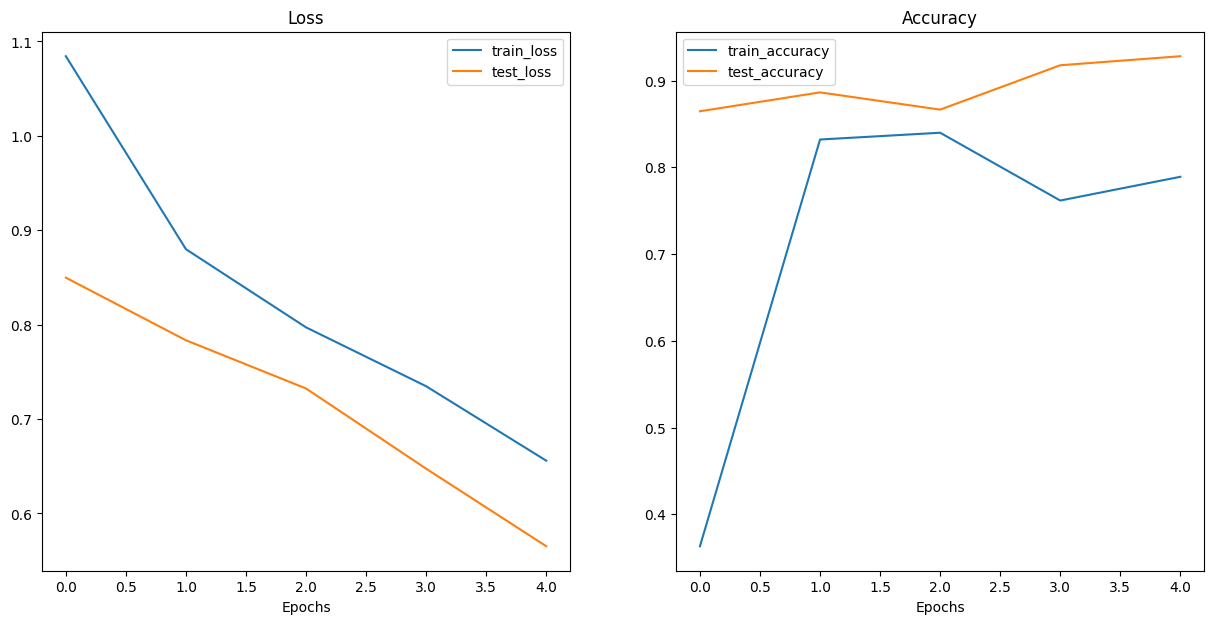

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

Creating a function to plot the and test the images

In [ ]:
from typing import List, Tuple
import torchvision
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

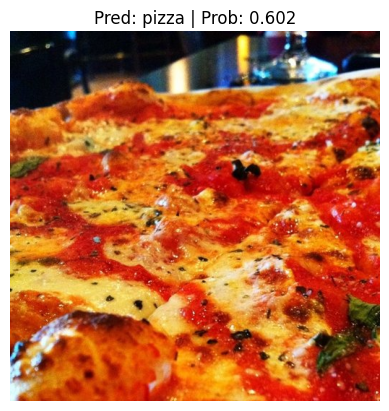

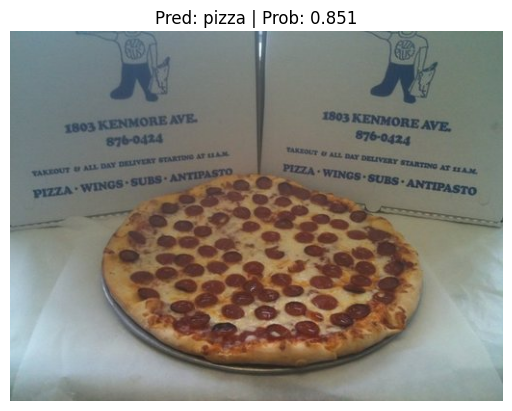

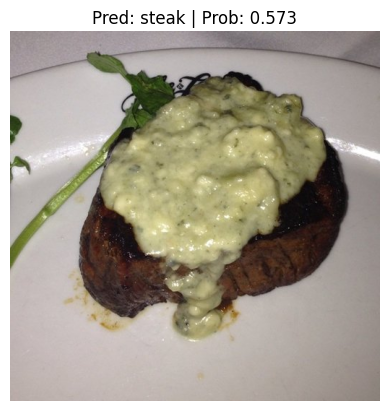

In [ ]:
# Get a random list of image paths from test set
import random
from pathlib import Path
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=num_classes,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### Making predictions on custom images

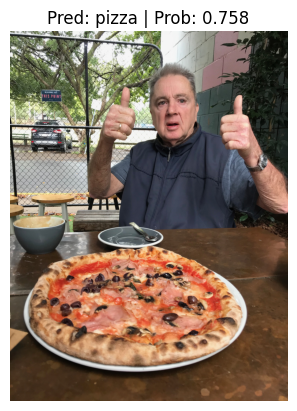

In [ ]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = DATA_PATH / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=num_classes)